<a href="https://colab.research.google.com/github/skauntey/ALMS-II-sentiment-analysis/blob/main/tf_ALMS_Model1_250421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# You may have to download the modules below
# Especially if you're using Colab

! pip install -q kaggle
! pip install gitpython

You should consider upgrading via the 'c:\users\eq\pycharmprojects\google_venv\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\eq\pycharmprojects\google_venv\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os, shutil
import kaggle
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline


### Installing Kaggle API in local computer / or on Colab
##### Make sure that kaggle.json file is available in home/.kaggle folder
##### Follow the 'API Credentials' on the Kaggle page (below) to find how to install Kaggle API.
##### https://github.com/Kaggle/kaggle-api

In [3]:
# Run this cell if you're using Google Colab
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json


The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
# Clone github package to work on local computer
# Change 'content' folder to your destination
# Make sure you remove '#' before cloning

import git
import os
repo = "https://github.com/skauntey/ALMS-II-sentiment-analysis.git"
file_path = str(os.getcwd()) # you can change this
def repo_download(repo):
    current_folder = str(os.getcwd())
    if current_folder.split('/')[-1] != 'ALMS-II-sentiment-analysis':
        if os.path.isdir('ALMS-II-sentiment-analysis'):
            print ('Repo exists!')
    else:
        git.Git(str(os.getcwd())).clone("https://github.com/skauntey/ALMS-II-sentiment-analysis.git")
    print('Repo cloned!)')

repo_download(repo)
#os.chdir(os.path.join(str(os.getcwd()), 'ALMS-II-sentiment-analysis'))
#os.getcwd() # make sure you are in ALMS-II-sentiment-analysis folder


Repo cloned!)


## 2. Downloading Data


In [6]:
## In order to download the dataset make sure that kaggle.json file is available in ~/.kaggle/kaggle.json
# 'Kaggle.json' Downloading instructions are available under 'API Credential' heading of the github page
# https://github.com/Kaggle/kaggle-api

import zipfile
#Define file to download

dataset = "sentiment-analysis-on-movie-reviews"

def kaggle_dataset_download(dataset):
    kaggle.api.authenticate()
    kaggle.api.competition_download_files(dataset, path= str(os.getcwd())+"/dataset/", force = True)
    kaggle.api.dataset_download_files('danielwillgeorge/glove6b100dtxt', path= str(os.getcwd())+"/glove_data/", force = True, unzip=True)
    print ('Data downloaded!')

def unzip_kaggle_file():

    # file_path
    zipped_file = os.listdir('dataset')[0]
    file_path = os.path.join(str(os.getcwd()), 'dataset', zipped_file)
    folder_path = os.path.join(str(os.getcwd()), 'dataset')

    # making sure that previously downloaded file, if any, is deleted before
    for file in os.listdir(folder_path):
        path = os.path.join(os.getcwd(), 'dataset', file)
        if path.split('.')[-1] != "zip":
            try:
                shutil.rmtree(path)
            except:
                raise

    # Unzipping the file
    with zipfile.ZipFile(file_path) as zip_file:
        for member in zip_file.namelist():
            if member.split('.')[-1] == "zip":
                fdir = member.split('.')[0]
                zip_file.extract(member, path= os.path.join('dataset/'+fdir))
                # extracting individual train and test files in their respective folders
                zippedfile_name = os.listdir(os.path.join(str(os.getcwd()+'/dataset/'+fdir+'/')))
                zippedfile = os.path.join(str(os.getcwd())+'/dataset/'+ fdir, zippedfile_name[0])
                with zipfile.ZipFile(zippedfile, mode='r') as tsv_zip:
                    tsv_zip.extractall(path = os.path.join('dataset/'+fdir+'/'))

                os.remove(zippedfile)
            else:
                continue

    os.remove(os.path.join(str(os.getcwd()), 'dataset', zipped_file))
    print('Kaggle file is downloaded and unzipped!')


kaggle_dataset_download(dataset)
unzip_kaggle_file()

Data downloaded!
Kaggle file is downloaded and unzipped!


## 3. Converting files to DATASETs

In [7]:
#C:\Users\eq\Documents\UCL\ELEC0135 ALMS II\ALMS-II-sentiment-analysis\dataset\train
file_path = os.path.join(str(os.getcwd()), 'dataset','train')
file = os.listdir(file_path)[0]
path = os.path.join(file_path, file)
# read the data
train_data = pd.read_csv(path, sep="\t")
label_class = [('negative', 0), ('somewhat negative', 1), ('neutral', 2), ('somewhat positive', 3), ('positive', 4)]

pdf = pd.DataFrame({
    'sentence_id' : train_data['SentenceId'],
    'text_reviews': train_data['Phrase'],
    'class_id': train_data['Sentiment'],
    'sentence_len': [len(x) for x in train_data['Phrase']],
    })

pdf['class_'] = [label_class[i][0] for i in pdf['class_id']]

pdf = pdf[pdf['sentence_len'] > 0]

pdf_data = pdf['text_reviews']
pdf_labels = pdf['class_id']

print(pdf_data.shape)
print(pdf_labels.shape)
pdf.head(10)

(156060,)
(156060,)


,sentence_id,text_reviews,class_id,sentence_len,class_
0,1,A series of escapades demonstrating the adage ...,1,188,somewhat negative
1,1,A series of escapades demonstrating the adage ...,2,77,neutral
2,1,A series,2,8,neutral
3,1,A,2,1,neutral
4,1,series,2,6,neutral
5,1,of escapades demonstrating the adage that what...,2,68,neutral
6,1,of,2,2,neutral
7,1,escapades demonstrating the adage that what is...,2,65,neutral
8,1,escapades,2,9,neutral
9,1,demonstrating the adage that what is good for ...,2,55,neutral


## 3.1 Pre-processing data

In [8]:
import re
from sklearn.model_selection import train_test_split
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def clean_text_func(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

def preprocessing_dataset(pdf_data, pdf):
    pdf_data = pdf_data.apply(clean_text_func)
    text_dataset = pdf[pdf_data.astype(bool)] 
    pdf = text_dataset.reset_index(drop = True)

    text_data = pdf['text_reviews']
    pdf_text_data = text_data.apply(clean_text_func)
    pdf['text_reviews'] = pdf_text_data
    return pdf

pdf = preprocessing_dataset(pdf_data,pdf)
pdf.head()
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155145 entries, 0 to 155144
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   sentence_id   155145 non-null  int64 
 1   text_reviews  155145 non-null  object
 2   class_id      155145 non-null  int64 
 3   sentence_len  155145 non-null  int64 
 4   class_        155145 non-null  object
dtypes: int64(3), object(2)
memory usage: 5.9+ MB


## 3.1.1 Creating a smaller dataset (DATASET B)

In [9]:
sen_numbers = [x for x in set(pdf['sentence_id'])]
def de_agument_text(pdf):
  strings  = []
  for i in sen_numbers:
    anew = pdf.loc[pdf['sentence_id'] == i].sort_values('sentence_len', ascending=False)
    seriess = anew[['text_reviews', 'class_id', 'sentence_len', 'class_']].iloc[0,0:4].values
    strings.append(seriess)
  return strings

pdf_compressed = pd.DataFrame(de_agument_text(pdf), columns=['text_reviews', 'class_id', 'sentence_len', 'class_'])
print(pdf_compressed.head())
print('Size of DATASET-A {}'.format(pdf.shape))
print('Size of DATASET-B {}'.format(pdf_compressed.shape))

                                        text_reviews  class_id  sentence_len  \
0  series escapades demonstrating adage good goos...         1           188   
1  quiet introspective entertaining independent w...         4            74   
2  even fans ismail merchant s work suspect hard ...         1           100   
3  positively thrilling combination ethnography i...         3           152   
4  aggressive selfglorification manipulative whit...         1            60   

              class_  
0  somewhat negative  
1           positive  
2  somewhat negative  
3  somewhat positive  
4  somewhat negative  
Size of DATASET-A (155145, 5)
Size of DATASET-B (8520, 4)


## 3.2 Data Representation (DATASET A & B)

<ipython-input-10-3ed9f7228534>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels = x, rotation =45)
<ipython-input-10-3ed9f7228534>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels = x, rotation =45)


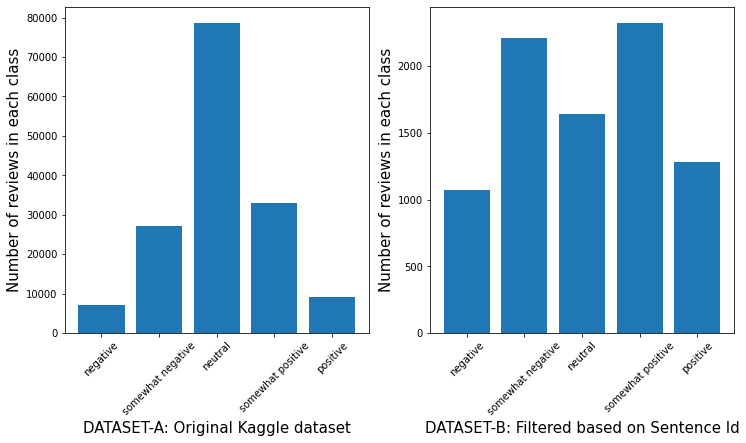

In [10]:
import matplotlib.pyplot as plt

labels = {'negative':0,'somewhat negative':1,'neutral': 2,'somewhat positive':3,'positive':4}
x = labels.keys()

y_compressed = pdf_compressed.groupby('class_id').text_reviews.count()

y_pdf = pdf.groupby('class_id').text_reviews.count()


fig, [ax1, ax2]= plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax2.bar(x, y_compressed)
ax2.set_xticklabels(labels = x, rotation =45)
ax2.set_xlabel('DATASET-B: Filtered based on Sentence Id', fontsize = 15)
ax2.set_ylabel('Number of reviews in each class', fontsize = 15)

ax1.bar(x, y_pdf)
ax1.set_xticklabels(labels = x, rotation =45)
ax1.set_xlabel('DATASET-A: Original Kaggle dataset', fontsize = 15)
ax1.set_ylabel('Number of reviews in each class', fontsize = 15)
plt.show()

### 3.2.1 Labels representation

In [11]:
from io import StringIO
id_class_df = pdf[['class_id', 'class_']].drop_duplicates().sort_values('class_id')
id_class = dict(id_class_df.values)
class_id_dict = dict(id_class_df[['class_', 'class_id']].values)
class_id_dict

{'negative': 0,
 'somewhat negative': 1,
 'neutral': 2,
 'somewhat positive': 3,
 'positive': 4}

## 4. train_test_split of datasets

In [12]:
# train_test split of DATASET A and DATASET B


print ("Numpy array of Original Dataset")
X_corpus_A = pdf.text_reviews.to_numpy()
y_labels_A = pdf.class_id.to_numpy()
X_corpus_B = pdf_compressed.text_reviews.to_numpy()
y_labels_B = pdf_compressed.class_id.to_numpy()


Numpy array of Original Dataset


In [13]:
#Verifying the datas shapes and type
print ('-' * 50)
print ("Info of Original Dataset")
print(type(X_corpus_A))
print(type(y_labels_A))
print(X_corpus_A.shape)
print(y_labels_A.shape)

print(type(X_corpus_B))
print(type(y_labels_B))
print(X_corpus_B.shape)
print(y_labels_B.shape)


--------------------------------------------------
Info of Original Dataset
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(155145,)
(155145,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(8520,)
(8520,)


## 5. Tokenzing and Padding of Text data

#### 5.1 Tokenizing and Padding using tensorflow Tokenizer

In [14]:
# Downloading TensorFlow modules
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
# calculating a total number of words from a clean dataset
def num_words (text_dataset):
    total_words = {}
    for x in text_dataset:
        for a in x.split():
            if a not in total_words.keys():
                total_words[a] = 1
            else:
                total_words[a] += 1
    return len(total_words.keys())

num_words_A = num_words(X_corpus_A)
print ('word count in DATASET- A {}.'.format(num_words_A))
num_words_B = num_words(X_corpus_B)
print ('word count in DATASET- B {}.'.format(num_words_B))

word count in DATASET- A 16260.
word count in DATASET- B 16190.


In [16]:
def tokenizing_dataset(text):
    tokenizer = Tokenizer(oov_token='<00V>')
    tokenizer.fit_on_texts(text)
    word_index = tokenizer.word_index
    return word_index, tokenizer

def max_len(text):
    _, tokenizer = tokenizing_dataset(text)
    sequences = tokenizer.texts_to_sequences(text)
    max_len = max([len(x) for x in sequences])
    return max_len, sequences

max_len_A,sequences_A = max_len(X_corpus_A)
max_len_B,sequences_B = max_len(X_corpus_B)

def sequencing_padding_dataset(text, max_len):
    word_index, tokenizer = tokenizing_dataset(text)
    text_sequences = tokenizer.texts_to_sequences(text)
    padded_text = pad_sequences(text_sequences, maxlen= max_len, truncating ='post', padding='post')
    return padded_text, text_sequences, word_index

padded_X_A, X_sequences_A, X_word_index_A = sequencing_padding_dataset(X_corpus_A, max_len_A)
padded_X_B, X_sequences_B, X_word_index_B = sequencing_padding_dataset(X_corpus_B, max_len_B)

print('DATASET A info.')
print(max_len_A)
print(type(padded_X_A))
print(type(X_sequences_A))
print(padded_X_A.shape)
print(len(X_sequences_A))
print(padded_X_A[0:2])
print(X_sequences_A[0:2])

print('DATASET B info.')
print(max_len_B)
print(type(padded_X_B))
print(type(X_sequences_B))
print(padded_X_B.shape)
print(len(X_sequences_B))
print(padded_X_B[0:2])
print(X_sequences_B[0:2])

DATASET A info.
31
<class 'numpy.ndarray'>
<class 'list'>
(155145, 31)
155145
[[  209 14971  5796  6392    12  3400    91    12 11253   513 10331   473
   1898    14     9     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [  209 14971  5796  6392    12  3400     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
[[209, 14971, 5796, 6392, 12, 3400, 91, 12, 11253, 513, 10331, 473, 1898, 14, 9], [209, 14971, 5796, 6392, 12, 3400]]
DATASET B info.
31
<class 'numpy.ndarray'>
<class 'list'>
(8520, 31)
8520
[[ 212 8029 4109 4110   15 4111   59   15 8030  448 8031  430 1743   16
    11    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [ 503 4112   90 3284  119 2687    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]
[[212, 8029, 4109,

#### 5.1.2 Train and Test split of the Padded Text and One-hot encoded Labels

In [17]:
# One-hot encoding of the label's dataset
split_size = 0.1
def one_hot_encoding (dataset_labels):
    labels_onehot = pd.get_dummies(dataset_labels)
    return labels_onehot
labels_onehot_A = one_hot_encoding(y_labels_A)
labels_onehot_B = one_hot_encoding(y_labels_B)

# Train, Test and Split of Padded text and One-hot encoded labels
X_train_A, X_test_A, Y_train_A_onehot, Y_test_A_onehot = train_test_split(padded_X_A, labels_onehot_A, test_size = split_size)
X_train_B, X_test_B, Y_train_B_onehot, Y_test_B_onehot = train_test_split(padded_X_B, labels_onehot_B, test_size = split_size)
print('Shape of dataset with one-hot encoding')
print(X_train_A.shape,Y_train_A_onehot.shape)
print(X_test_A.shape,Y_test_A_onehot.shape)
print(X_train_B.shape,Y_train_B_onehot.shape)
print(X_test_B.shape,Y_test_B_onehot.shape)

# Train, Test and Split of Padded text for Sparse Categorical entropy
X_train_A, X_test_A, Y_train_A, Y_test_A = train_test_split(padded_X_A, y_labels_A, test_size = split_size)
X_train_B, X_test_B, Y_train_B, Y_test_B = train_test_split(padded_X_B, y_labels_B, test_size = split_size)
print('Shape of dataset without one hot encoding')
print(X_train_A.shape,Y_train_A.shape)
print(X_test_A.shape,Y_test_A.shape)
print(X_train_B.shape,Y_train_B.shape)
print(X_test_B.shape,Y_test_B.shape)


Shape of dataset with one-hot encoding
(139630, 31) (139630, 5)
(15515, 31) (15515, 5)
(7668, 31) (7668, 5)
(852, 31) (852, 5)
Shape of dataset without one hot encoding
(139630, 31) (139630,)
(15515, 31) (15515,)
(7668, 31) (7668,)
(852, 31) (852,)


#### 5.1.3. Verifying padded sequence with the original text

In [ ]:
def decoding_sequences(dataset_text, text_sequences):
    word_index, _ = tokenizing_dataset(dataset_text)
    reversed_index = dict(map(reversed, word_index.items()))
    for letter in range(len(reversed_index)):
        reversed_index.get(letter)

    reversed_sequence = [reversed_index.get(letter) for letter in text_sequences]
    return ' '.join(reversed_sequence)
    
# print(decoding_sequences(pdf_dataset_data, pdf_sequences))
print(decoding_sequences(X_corpus_A, X_sequences_A[0]))
print(X_corpus_A[0])

### 5.2 Word Embedding using Pre-Trained Glove dataset

In [ ]:
# downloading module and packages
#If error occurs please download the wget package in the cell above
from kaggle.api.kaggle_api_extended import KaggleApi
import external_dataset
from external_dataset.glove import download_GloveDataset
from external_dataset.glove import embedding_GloveDataset

url = 'danielwillgeorge/glove6b100dtxt'
glove_path = download_GloveDataset(url)
embedded_glove = embedding_GloveDataset(glove_path, X_word_index_A)
print(embedded_glove['the'])

Glove data has been embedded.
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028 

## 6. Building Model

In [ ]:
# downloading tensorflow modules
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Embedding, SpatialDropout1D, BatchNormalization, Bidirectional, Activation
from tensorflow.keras.models import Sequential

In [18]:
# importing modules from package
from tf_models.rnn_lstm_gru import simple_rnn
from tf_models.rnn_lstm_gru import bi_directional_rnn_lstm
from tf_models.rnn_lstm_gru import simple_rnn_glove
from tf_models.rnn_lstm_gru import bi_directional_rnn_lstm_glove

vocabulary_size = len(X_word_index_A) + 1
embedding_dim = 100

max_length = X_train_A.shape[1]
trunc_type = 'post'
oov_tok = '<00V>'

model = simple_rnn(vocabulary_size, embedding_dim, max_length)

model.compile(loss= tf.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, decay = 0.0001),
              metrics= ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 100)           1626000   
_________________________________________________________________
flatten (Flatten)            (None, 3100)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                99232     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 1,725,397
Trainable params: 1,725,397
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
num_epochs = 10
batch_size = 5000
history = model.fit(X_train_A, Y_train_A, batch_size=batch_size, epochs = num_epochs, validation_data=(X_test_A, Y_test_A))

Epoch 1/10
28/28 [==============================] - 9s 224ms/step - loss: 1.3490 - accuracy: 0.4616 - val_loss: 1.1835 - val_accuracy: 0.5167

In [20]:
accr = model.evaluate(X_test_A,Y_test_A)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

485/485 [==============================] - 1s 1ms/step - loss: 1.0867 - accuracy: 0.6378

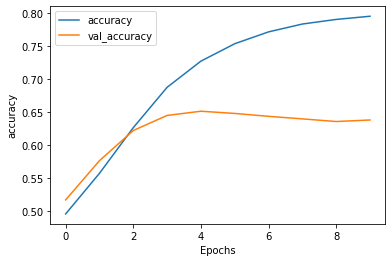

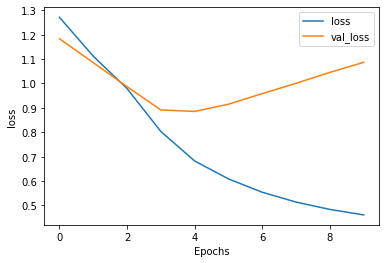

In [21]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)